## Active Learning

Download the titanic dataset here: https://drive.google.com/file/d/0Bz9_0VdXvv9bbVhpOEMwUDJ2elU/view?usp=sharing

In this exercise, we will simulate active learning. We will keep the small sample of observations for testing and we will test how quality of the model rises when we use active learning to choose labeled observations.

In [1]:
# Load the Data into variable df
import pandas as pd

df = pd.read_csv('train.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
# Pclass is actually a categorical feature - convert to string
df['Pclass'] = df['Pclass'].astype(str)

In [4]:
# TEST SAMPLE
# USE THIS SAMPLE ONLY FOR TESTING
test_df = df.sample(n=100, random_state=42)
# KEEP ONLY THOSE WHO ARE NOT IN THE TEST SET
df = df[~df.PassengerId.isin(test_df.PassengerId.tolist())]

In [5]:
# FIT THE FIRST MODEL ONLY ON THE DATAFRAME START_DF
start_df = df.sample(n=100, random_state=42)
# DROP OBS FROM START_DF FROM DF
df = df[~df.PassengerId.isin(start_df.PassengerId.tolist())]

### Tasks

1. fit the first model only on the **start_df** using **SVM** and evaluate accuracy, precision and recall on test_df
2. in each iteration, add 10 observations from **df** to your trainset (choose the observation using active learning approach) 
    - score all observations in df and take 10 where the model isn't sure what class it is. The probability of surviving will be around 50% 
3. refit the model and evaluate on **test_df** again.    
3. the goal is to converge to the optimal solution as fast as possible by choosing **right** observations in each iteration
4. plot the graphs for each eval metric, where on the axis x is iteration number, on y is the metric value for that model

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

numeric_transform = Pipeline([('impute_mean', SimpleImputer(strategy='mean')), 
                              ('scaling', StandardScaler())])

categorical_transform = Pipeline([('impute_mode', SimpleImputer(strategy='most_frequent')), 
                                  ('one-hot-encode', OneHotEncoder(sparse=False))])

preprocessing = ColumnTransformer([('numeric', numeric_transform, ['Age', 'SibSp', 'Parch', 'Fare']), 
                                        ('categorical', categorical_transform, ['Pclass', 'Sex', 'Embarked'])])

pipeline = Pipeline([('preprocessing', preprocessing), 
                          ('model', SVC(gamma='auto',  probability=True))])

In [7]:
def fit_score(df, start_df, test_df):

    # FIT
    X_train = start_df.drop(columns=['Survived'])
    X_test = test_df.drop(columns=['Survived'])
    y_train = start_df['Survived']
    y_test = test_df['Survived']

    pipeline.fit(X_train, y_train)

    # PREDICT
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    # EVALUATE
    y_train = y_train.reset_index(drop = True)
    y_test = y_test.reset_index(drop = True)

    compare_train = pd.concat([y_train, pd.Series(y_train_pred)], axis=1)
    compare_test = pd.concat([y_test, pd.Series(y_test_pred)], axis=1)

    compare_train = compare_train.rename(columns={compare_train.columns[0]: 'y_train', 
                                    compare_train.columns[1]: 'y_train_pred',
                                    })
    compare_test = compare_test.rename(columns={compare_test.columns[0]: 'y_test', 
                                    compare_test.columns[1]: 'y_test_pred',
                                    })

    # calculations to get precision and recall
    TP_train = len(compare_train.loc[(compare_train['y_train']==compare_train['y_train_pred'])&(compare_train['y_train_pred']==1)])
    FP_train = len(compare_train.loc[(compare_train['y_train']!=compare_train['y_train_pred'])&(compare_train['y_train_pred']==1)])
    FN_train = len(compare_train.loc[(compare_train['y_train']!=compare_train['y_train_pred'])&(compare_train['y_train_pred']==0)])

    TP_test = len(compare_test.loc[(compare_test['y_test']==compare_test['y_test_pred'])&(compare_test['y_test_pred']==1)])
    FP_test = len(compare_test.loc[(compare_test['y_test']!=compare_test['y_test_pred'])&(compare_test['y_test_pred']==1)])
    FN_test = len(compare_test.loc[(compare_test['y_test']!=compare_test['y_test_pred'])&(compare_test['y_test_pred']==0)])

    acc_train = pipeline.score(X_train, y_train)
    precision_train = TP_train/(TP_train+FP_train)
    recall_train = TP_train/(TP_train+FN_train)

    acc_test = pipeline.score(X_test, y_test)
    precision_test = TP_test/(TP_test+FP_test)
    recall_test = TP_test/(TP_test+FN_test)
    
    # PREDICT ON FULL DATASET
    X = df.drop(columns=['Survived'])
    y = df['Survived']
    
    y_pred = pipeline.predict(X)
    y_proba = pipeline.predict_proba(X)

    compare_df = pd.DataFrame()

    y_proba_0 = []
    y_proba_1 = []

    for item in y_proba:
        y_proba_0.append(item[0])
        y_proba_1.append(item[1])

    compare_df['Survived'] = y
    compare_df['y_pred'] = y_pred
    compare_df['prob_0'] = y_proba_0
    compare_df['prob_1'] = y_proba_1

    # SELECT TOP 10 MOST UNCERTAIN PREDICTIONS
    compare_df['dist_from_.5'] = np.abs(0.5 - compare_df['prob_0'])

    iteration = compare_df.sort_values(by='dist_from_.5').head(10)
    
    # UPDATE START_DF AND DF
    start_df = pd.concat([start_df, df[df.index.isin(iteration.index.tolist())]])

    df = df[~df.index.isin(start_df.index.tolist())]

    return df, start_df, acc_train, precision_train, recall_train, acc_test, precision_test, recall_test

[Text(0.5, 0, 'Iterations'), Text(0, 0.5, 'Test Recall')]

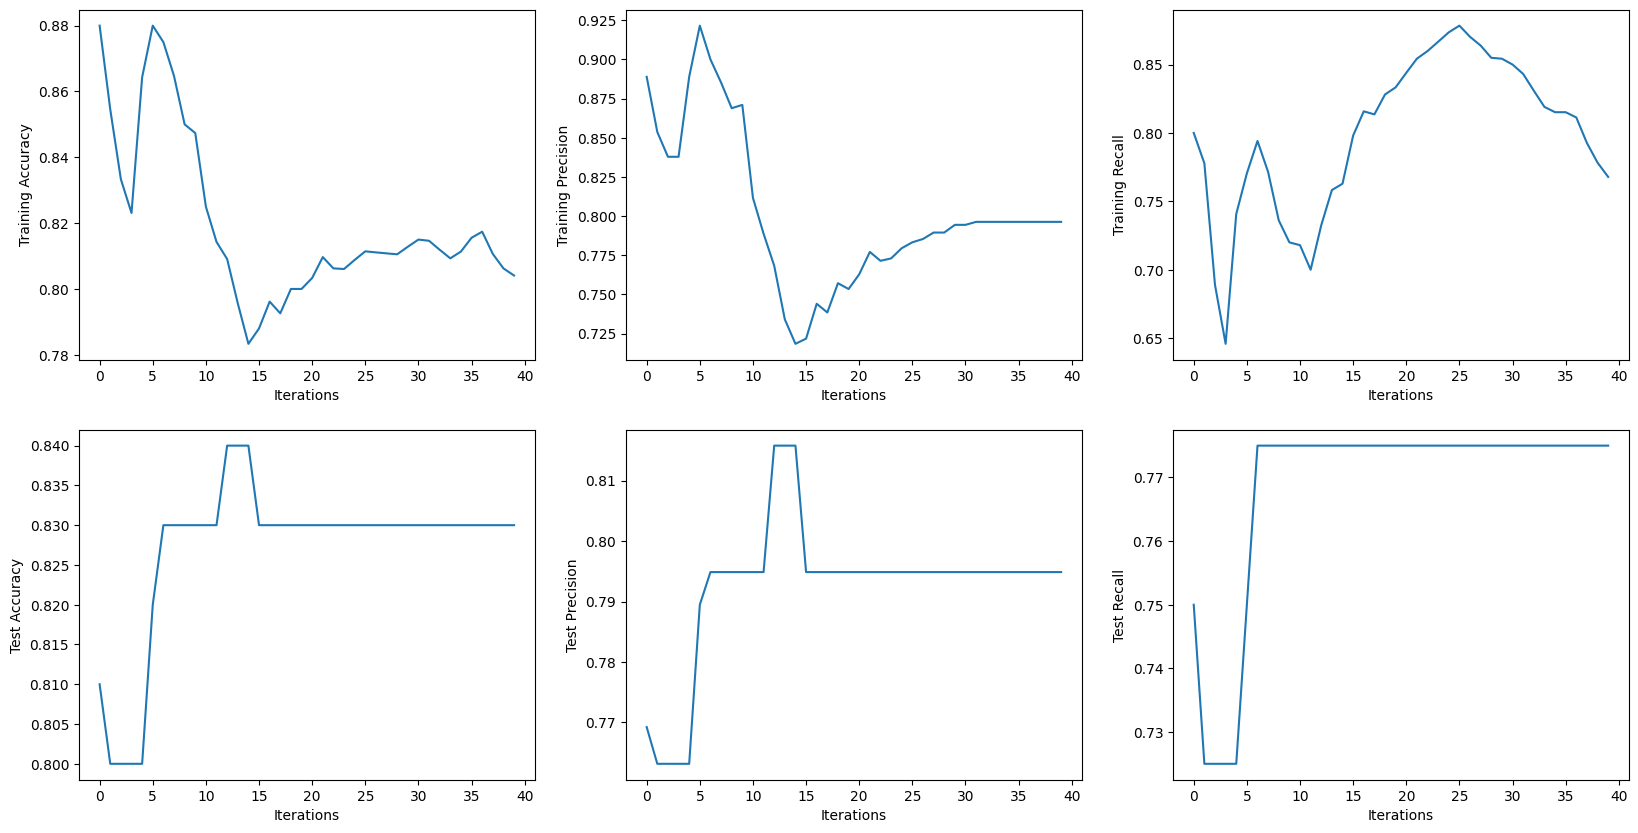

In [8]:
max_iter = 40

iteration_list = []

acc_train_list = []
precision_train_list = []
recall_train_list = []
acc_test_list = []
precision_test_list = []
recall_test_list = []

for i in range(0, max_iter):   
    df, start_df, acc_train, precision_train, recall_train, acc_test, precision_test, recall_test = fit_score(df, start_df, test_df)
    iteration_list.append(i)
    acc_train_list.append(acc_train)
    precision_train_list.append(precision_train)
    recall_train_list.append(recall_train)
    acc_test_list.append(acc_test)
    precision_test_list.append(precision_test)
    recall_test_list.append(recall_test)

fig, axes = plt.subplots(2,3, figsize=(20,10))
sns.lineplot(ax=axes[0][0], x=iteration_list, y=acc_train_list).set(xlabel= 'Iterations', ylabel='Training Accuracy')
sns.lineplot(ax=axes[0][1], x=iteration_list, y=precision_train_list).set(xlabel= 'Iterations', ylabel='Training Precision')
sns.lineplot(ax=axes[0][2], x=iteration_list, y=recall_train_list).set(xlabel= 'Iterations', ylabel='Training Recall')
sns.lineplot(ax=axes[1][0], x=iteration_list, y=acc_test_list).set(xlabel= 'Iterations', ylabel='Test Accuracy')
sns.lineplot(ax=axes[1][1], x=iteration_list, y=precision_test_list).set(xlabel= 'Iterations', ylabel='Test Precision')
sns.lineplot(ax=axes[1][2], x=iteration_list, y=recall_test_list).set(xlabel= 'Iterations', ylabel='Test Recall')

About 5-10 iterations gives the model with the best performance.